In [3]:
#Env Gurobi
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import csv
import xarray as xr
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import matplotlib.colors as mcolors

# System Parameters

In [4]:
RatedPower_Generation=300#[MW] #Maximum amout of power the transmission line can carry

# Cable Parameters

In [5]:
#AC cables (Three-core cables with copper wire screen)
dataframe1 = pd.read_excel('AC_Cables.xlsx')
AC_CableData=dataframe1.loc[0:75,:]

dataframe2 = pd.read_excel('DC_Cables.xlsx')
DC_CableData=dataframe2.loc[0:7:]

In [7]:
def Admitance(idxCable, LineLength,RatedPower_Generation, AC_CableData):
    #LineLength in [km]
    #AC_CableData: excel table with AC cable data
    #idxCable: index of the cable you are investigating
    
    V=AC_CableData['Voltage [KV]'][idxCable]
    R=AC_CableData['Resistance [Ohm/Km]'][idxCable]
    C=AC_CableData['Capacitance [MicroF/Km]'][idxCable]
    L=AC_CableData['Inductance [mF/Km]'][idxCable]
    Max_MVA=AC_CableData[" MVA Capacity"][idxCable]
    
    Cost_PM=AC_CableData['Cable Cost [$/m]'][idxCable]
    
    Gamma=np.sqrt((R + (2*np.pi*60*L*10**(-3))*1.j)*(2*np.pi*60*C*10**(-6)*1.j))
    Y=2*np.pi*60*C*10**(-6)*LineLength*np.tanh(Gamma*LineLength/2)/(Gamma*LineLength/2)*1.j #Admitance
    Q=Y.imag*V**2 #MVar #Reactive power
    
    
    
    #MaxP_Allowed: Max MW possible to transmit
    if (Max_MVA**2-(Q/2)**2)<=0:
        MaxP_Allowed=-1
        S_LT=-1
        NumConductors=0 #the cable cannot be used to trasmit power for this system
        #It would only carry reactive power
        
    else:
        MaxP_Allowed=np.sqrt(Max_MVA**2-(Q/2)**2) #Per conductor
        if  RatedPower_Generation>MaxP_Allowed:
            NumConductors=np.ceil(RatedPower_Generation/MaxP_Allowed)
            
        if  RatedPower_Generation<=MaxP_Allowed:
            NumConductors=1

        S_LT=Max_MVA*NumConductors # Total power capacity of the line [MVA]
    
    return Q*NumConductors, MaxP_Allowed, Y, Gamma, NumConductors, S_LT
    

In [8]:
def Efficiency_AC(D_SL,RatedPower_Generation, idxCable,AC_CableData, NumConductors, CF=0.5):
    V=AC_CableData['Voltage [KV]'][idxCable]
    R=AC_CableData['Resistance [Ohm/Km]'][idxCable]
    C=AC_CableData['Capacitance [MicroF/Km]'][idxCable]
    L=AC_CableData['Inductance [mF/Km]'][idxCable]
    Max_MVA=AC_CableData[" MVA Capacity"][idxCable]
    
    RatedPower_Generation=RatedPower_Generation*CF
    EffTransformer=EffTransformer=0.997 
    LT_Length=D_SL*1.2# Line length [km], considered 120% of shore distance

    TRL_OFF_AC=(1-EffTransformer)*RatedPower_Generation
    LC_AC=NumConductors*R*LT_Length*((RatedPower_Generation*EffTransformer/(V*NumConductors))**2)#Cable energy losses [MW]

    TRL_ON_AC=(RatedPower_Generation*EffTransformer-LC_AC)*(1-EffTransformer)# Onshore terminal losses [MW]
    
    LossesAC=TRL_OFF_AC+LC_AC+TRL_ON_AC
    EfficiencyAC=1-LossesAC/(RatedPower_Generation)
        
    return LossesAC, EfficiencyAC

In [9]:
def AnnualizedCostTL_AC(idxCable, D_SL, RatedPower_Generation, AC_CableData):
    
    LineLength=D_SL*1.2# Line length [km], considered 120% of shore distance
    Q,MaxP_Allowed, Y, Gamma, NumConductors, S_LT=Admitance(idxCable, LineLength,RatedPower_Generation, AC_CableData)
    Cost_PM=AC_CableData['Cable Cost [$/m]'][idxCable]*10**-3 #[M$/km]
    
    
    
    if NumConductors!=0:
        
        LossesAC, EfficiencyAC=Efficiency_AC(D_SL,RatedPower_Generation, idxCable,AC_CableData, NumConductors, CF=1)
        
        
        FCR=0.113 #Factor of capital retrun
        OPPC_AC=6.55 + 0.0472*S_LT #Platform and plant cost HVAC [M$]
        OPC_AC=0.03434*S_LT**(0.7513)# Onshore plant cost [M$]
        QC_AC=0.0262*Q# Cost of reactive power compensation [M$]

        CC_AC=Cost_PM*NumConductors*LineLength + 0.221*D_SL + 4.245*10**-3*S_LT + 0.629# Cable cost + cable landing + cable instalation [M$
        CAPEX_AC=OPPC_AC+OPC_AC+QC_AC+CC_AC# Capital expenditures [M$]


        OPEX_AC=0.025*CAPEX_AC# Operational Expenditures [M$/year]

        AnnualizedTC_AC=FCR*CAPEX_AC + OPEX_AC# Anualized transmission costs [M$/year]
        
    else:
        AnnualizedTC_AC=-1
        EfficiencyAC=-1
    
    return AnnualizedTC_AC, NumConductors, EfficiencyAC


### DC system

In [10]:
def Efficiency_DC(D_SL,RatedPower_Generation, idxCable, DC_CableData, NumConductors, CF=0.5):
    EffConverter=0.982 #Efficiency of the transformer
    LineLength=D_SL*1.2# Line length [km], considered 120% of shore distance
    S_LT=RatedPower_Generation*CF
    
    V=DC_CableData['Voltage [KV]'][idxCable]
    R=DC_CableData['Resistance [Ohm/Km]'][idxCable]
    Max_MVA=DC_CableData[" MVA Capacity"][idxCable]
    CableCostDC=DC_CableData['Cable Cost [$/m]'][idxCable]
    
    TRL_OFF_DC=(1-EffConverter)*S_LT#Offshore terminal losses [MW]
    LC_DC=2*R*LineLength*((S_LT*EffConverter/(2*V*NumConductors))**2)#Cable energy losses [MW]
    TRL_ON_DC=(S_LT*EffConverter-LC_DC)*(1-EffConverter) # Onshore terminal losses [MW]
    LossesDC=TRL_OFF_DC+LC_DC+TRL_ON_DC
    EfficiencyDC=1-LossesDC/(S_LT)
        
    return EfficiencyDC

In [11]:

def AnnualizedCostTL_DC(idxCable, D_SL, RatedPower_Generation, DC_CableData):
    EffConverter=0.982 #Efficiency of the transformer
    LineLength=D_SL*1.2# Line length [km], considered 120% of shore distance
    FCR=0.113 #Factor of capital retrun
    
    S_LT=RatedPower_Generation
    V=DC_CableData['Voltage [KV]'][idxCable]
    R=DC_CableData['Resistance [Ohm/Km]'][idxCable]
    Max_MVA=DC_CableData[" MVA Capacity"][idxCable]
    CableCostDC=DC_CableData['Cable Cost [$/m]'][idxCable]*10**-3
    
    NumConductors=np.ceil(RatedPower_Generation/Max_MVA)
    
    OPPC_DC=32.75 + 0.07205*S_LT #Platform and plant cost HVDC [M$]
    OPC_DC=0.1067*S_LT # Onshore plant cost [M$]
    
    
    CC_DC=CableCostDC*NumConductors*LineLength + 0.221*D_SL + 4.245*10**-3*S_LT + 0.629# Cable cost + cable landing + cable instalation [M$]
    CAPEX_DC=OPPC_DC+OPC_DC+CC_DC # Capital expenditures [M$]
    
    OPEX_DC=0.025*CAPEX_DC# Operational Expenditures [M$/year]
    
    AnnualizedTC_DC=FCR*CAPEX_DC + OPEX_DC# Anualized transmission costs [M$/year]
    
    EfficiencyDC=Efficiency_DC(D_SL,RatedPower_Generation, idxCable, DC_CableData, NumConductors, CF=0.5)
    
    return AnnualizedTC_DC, NumConductors, EfficiencyDC

# Functions To Compute Distance From Shore and Depths

In [12]:
Depth_NETCDF = xr.open_dataset("./Depths.nc")
#Get coastline data
CoastLine=[]

File_CoastLine=open('./GEO_data/Coastline_NC.csv', "r")
File_CoastLine_csv=csv.reader(File_CoastLine,delimiter=',')

for EachLine in File_CoastLine_csv:

    if File_CoastLine_csv.line_num > 1:
        CoastLine.append([float(EachLine[1]), float(EachLine[0])] ) #LatLong

CoastLine=np.array(CoastLine)


#Distance between two lat long points
def DistanceToShore (CoastLine, LatLong1): #Compute distance to shore in km of a lat long point
   
    CoastLine=CoastLine*2*np.pi/360
    LatLong1=LatLong1*2*np.pi/360
    
    LatLong1=np.reshape(LatLong1,(1,2))
    dLat=LatLong1[:,0]-CoastLine[:,0]
    dLong=LatLong1[:,1]-CoastLine[:,1]
    
    a=np.power(np.sin(dLat/2),2)+np.cos(CoastLine[:,0])*np.cos(LatLong1[:,0])*np.power(np.sin(dLong/2),2)
    c=2*np.arcsin(np.minimum(1,np.sqrt(a)))
    d=6367*c
    
    Distance=np.min(d) #Minimum distance to shore km
    
    return Distance

#Compute depth in a given location
def GetDepth(Lat,Long):
    
    I_lat=np.argmin(np.square(Depth_NETCDF.lat.data-Lat))
    I_lon=np.argmin(np.square(Depth_NETCDF.lon.data-Long))
    
    distError=(np.square(Depth_NETCDF.lat.data[I_lat]-Lat)+np.square(Depth_NETCDF.lon.data[I_lon]-Long))**0.5
    
    depth=Depth_NETCDF.elevation.data[I_lat,I_lon]  
    
    return depth, distError



In [18]:
#Create Grid
LatLong=[]
lat_min, lat_max=33.5 , 37+1/10
lon_min, lon_max=-78.5 , -74.5+1/10

xlim =[lon_min,lon_max]
ylim=[lat_min, lat_max]

lat_range = np.linspace(lat_min, lat_max,int((lat_max-lat_min)*10))
lon_range = np.linspace(lon_min, lon_max, int((lon_max-lon_min)*10))
        
LatLong = np.array(np.meshgrid(lat_range,lon_range)).T.reshape(-1, 2)

In [19]:
#Minimum distance from shore
ShoreDistance=[]
for LatLong1 in LatLong:
    Distance=DistanceToShore(CoastLine, LatLong1)
    ShoreDistance.append(Distance)

ShoreDistance=np.array(ShoreDistance)


DepthAllSites=[]
for i in range(LatLong.shape[0]):
    Depth, Error=GetDepth(LatLong[i,0],LatLong[i,1])#Get depth for each .mat site location
    
    DepthAllSites.append(Depth)
    
DepthAllSites=-np.array(DepthAllSites)

IdxFeasibleSites=(ShoreDistance>2)*(DepthAllSites>9)
#IdxFeasibleSites=(DepthAllSites>10)

#Filter sites
LatLong=LatLong[IdxFeasibleSites,:]
DepthAllSites=DepthAllSites[IdxFeasibleSites]
ShoreDistance=ShoreDistance[IdxFeasibleSites]

# Plots

In [20]:
ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
df = gpd.read_file(ShapeFileCoast)
df1 = gpd.read_file(ShapeFileStates)


## Depth

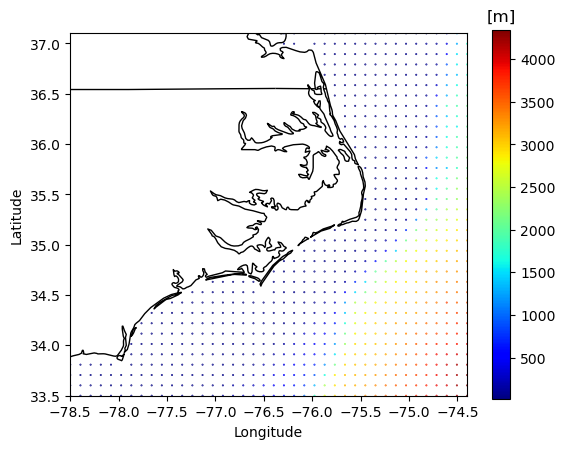

In [21]:
#### Distance
fig, ax = plt.subplots(figsize  = None)


df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)

plt.scatter(LatLong[:,1],LatLong[:,0],c=DepthAllSites, s=0.2, cmap="jet")

clb = plt.colorbar()
clb.ax.set_title('[m]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.savefig('Figures/Depth.png',bbox_inches='tight',dpi=700)


## Shore Distance

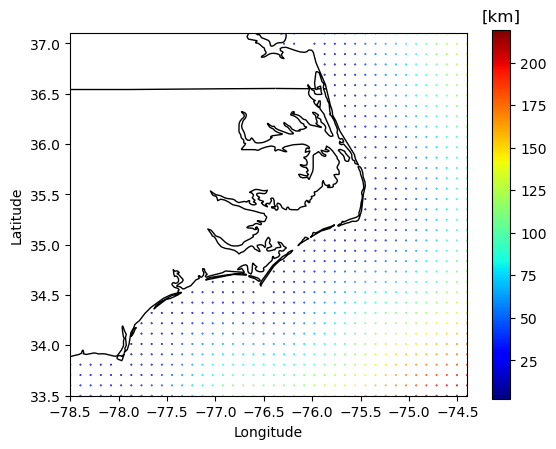

In [22]:
#### Distance
fig, ax = plt.subplots(figsize  = None)

df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)

plt.scatter(LatLong[:,1],LatLong[:,0],c=ShoreDistance, s=0.2, cmap='jet')

clb = plt.colorbar()
clb.ax.set_title('[km]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.savefig('Figures/DistanceShore.png',bbox_inches='tight',dpi=700)


## Costs Transmission

In [23]:
IdxFeasibleSites=(DepthAllSites<2500)
#IdxFeasibleSites=(DepthAllSites>10)

#Filter sites
LatLong=LatLong[IdxFeasibleSites,:]
DepthAllSites=DepthAllSites[IdxFeasibleSites]
ShoreDistance=ShoreDistance[IdxFeasibleSites]

In [24]:
#Minimum distance from shore
S_BestCable=[]
S_BestACost=[]
S_Efficiency=[]
S_Mode=[]

for i in tqdm(range(len(ShoreDistance))):
    D_SL=ShoreDistance[i]
    
    MinMarginalCost=np.inf
    BestCable=-1
    Best_Efficiency=-1
    MinCost=-1
    Mode=-1
    for idxCable in range(len(AC_CableData)):
        Annual_Cost,_,EfficiencyAC=AnnualizedCostTL_AC(idxCable, D_SL, RatedPower_Generation, AC_CableData)
        
        if Annual_Cost!=-1:
            MarginalCost=Annual_Cost*10**6+83.345*RatedPower_Generation*0.5*8760*(1-EfficiencyAC) #83$ from https://atb.nrel.gov/electricity/2022/offshore_wind
        
            if MinMarginalCost>MarginalCost :
                MinMarginalCost=MarginalCost
                
                MinCost=Annual_Cost
                BestCable=idxCable
                Best_Efficiency=EfficiencyAC
                Mode=0 #HVAC

# DC Transmission
    for idxCable in range(len(DC_CableData)):
        Annual_Cost, _, EfficiencyDC=AnnualizedCostTL_DC(idxCable, D_SL, RatedPower_Generation, DC_CableData)
        
        if Annual_Cost!=-1:
            MarginalCost=Annual_Cost*10**6+83.345*RatedPower_Generation*0.5*8760*(1-EfficiencyDC) #83$ from https://atb.nrel.gov/electricity/2022/offshore_wind
        
            if MinMarginalCost>MarginalCost :
                MinMarginalCost=MarginalCost
                
                MinCost=Annual_Cost
                BestCable=idxCable
                Best_Efficiency=EfficiencyDC
                Mode=1 #HVDC
       
    S_BestCable.append(BestCable)
    S_BestACost.append(MinCost)
    S_Efficiency.append(Best_Efficiency)
    S_Mode.append(Mode)
  

S_BestACost=np.array(S_BestACost)
S_BestCable=np.array(S_BestCable)
S_Efficiency=np.array(S_Efficiency)
S_Mode=np.array(S_Mode)
LCOE=S_BestACost*10**6/(RatedPower_Generation*0.5*8760*S_Efficiency) #[$/MWh*year]

100%|██████████| 554/554 [00:02<00:00, 223.98it/s]


In [31]:
IdxFeasibleSites=S_BestACost>0
LCOE=LCOE[IdxFeasibleSites]
LatLong=LatLong[IdxFeasibleSites,:]
S_Efficiency=S_Efficiency[IdxFeasibleSites]
S_Mode=S_Mode[IdxFeasibleSites]
S_BestACost=S_BestACost[IdxFeasibleSites]

np.savez("Transmission_300MW", LatLong=LatLong, S_Efficiency=S_Efficiency, S_BestACost=S_BestACost)

## LCOE

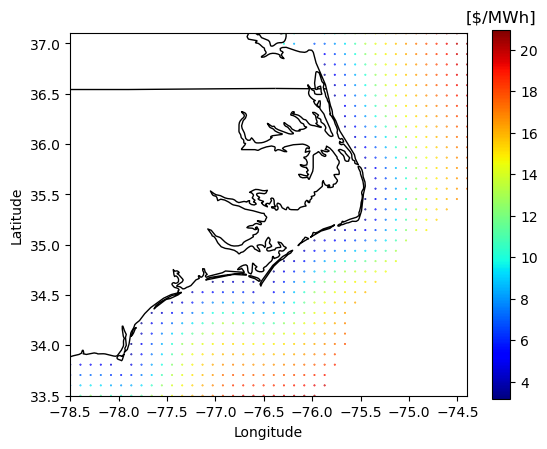

In [25]:

fig, ax = plt.subplots(figsize  = None)

df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)

plt.scatter(LatLong[:,1],LatLong[:,0],c=LCOE, s=0.2, cmap='jet')

clb = plt.colorbar()
clb.ax.set_title('[$/MWh]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.savefig('Figures/LCOETransmission_'+str(RatedPower_Generation)+'MW.png',bbox_inches='tight',dpi=700)

## Efficiency

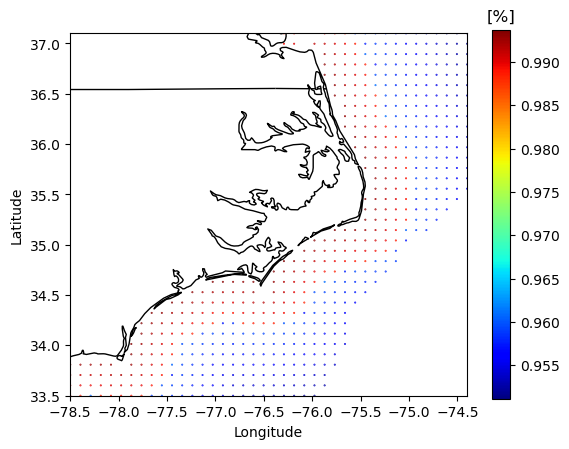

In [32]:
fig, ax = plt.subplots(figsize  = None)

df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)

plt.scatter(LatLong[:,1],LatLong[:,0],c=S_Efficiency, s=0.2, cmap='jet')

clb = plt.colorbar()
clb.ax.set_title('[%]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.savefig('Figures/EfficiencyTransmission_'+str(RatedPower_Generation)+'MW.png',bbox_inches='tight',dpi=700)

## Mode

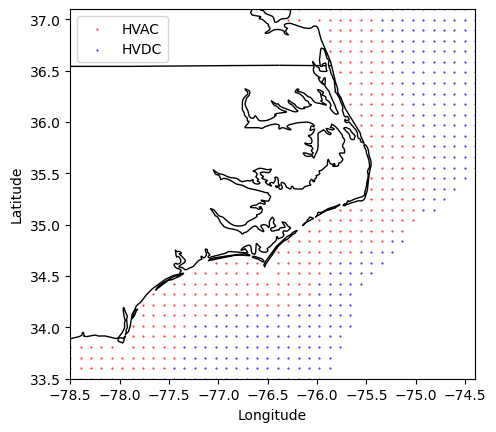

In [33]:
fig, ax = plt.subplots(figsize  = None)

df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)

plt.scatter(LatLong[S_Mode==0,1],LatLong[S_Mode==0,0], s=0.2, c='r',label="HVAC")
plt.scatter(LatLong[S_Mode==1,1],LatLong[S_Mode==1,0], s=0.2, c='b',label="HVDC")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.savefig('Figures/ModeTransmission_'+str(RatedPower_Generation)+'MW.png',bbox_inches='tight',dpi=700)